## What am I actually parameterizing?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm_notebook as tqdm
from L96 import *
from copy import copy, deepcopy
import pdb
import multiprocessing as mp

In [6]:
class L96TwoLevelUncoupled(object):
    def __init__(self, K=36, J=10, h=1, F=10, c=10, b=10, dt=0.001,
                 X_init=None, Y_init=None, noprog=False, noYhist=False, save_dt=0.1):
        self.K, self.J, self.h, self.F, self.c, self.b, self.dt = K, J, h, F, c, b, dt
        self.noprog, self.noYhist = noprog, noYhist
        self.step_count = 0
        self.save_steps = int(save_dt / dt)
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy()
        self.Y = np.zeros(self.K * self.J) if Y_init is None else Y_init.copy()
        self._history_X = [self.X.copy()]
        self._history_Y_mean = [self.Y.reshape(self.K, self.J).mean(1).copy()]
        self._history_Y2_mean = [(self.Y.reshape(self.K, self.J)**2).mean(1).copy()]
        self._history_B = [-self.h * self.c * self.Y.reshape(self.K, self.J).mean(1)]
        if not self.noYhist:
            self._history_Y = [self.Y.copy()]


    def _rhs_X(self, X, B):
        """Compute the right hand side of the X-ODE."""
        dXdt = (
                -np.roll(X, -1) * (np.roll(X, -2) - np.roll(X, 1)) -
                X + self.F + B
        )
        return dXdt

    def _rhs_Y(self, X, Y):
        """Compute the right hand side of the Y-ODE."""
        dYdt = (
                       -self.b * np.roll(Y, -1) * (np.roll(Y, -2) - np.roll(Y, 1)) -
                       Y + self.h / self.J * np.repeat(X, self.J)
               ) * self.c
        return dYdt

    def step(self):
        # First get solution for X without updating Y
        B = -self.h * self.c * self.Y.reshape(self.K, self.J).mean(1)

        k1_X = self.dt * self._rhs_X(self.X, B)
        k2_X = self.dt * self._rhs_X(self.X + k1_X / 2, B)
        k3_X = self.dt * self._rhs_X(self.X + k2_X / 2, B)
        k4_X = self.dt * self._rhs_X(self.X + k3_X, B)

        # Then update Y with unupdated X
        k1_Y = self.dt * self._rhs_Y(self.X, self.Y)
        k2_Y = self.dt * self._rhs_Y(self.X, self.Y + k1_Y / 2)
        k3_Y = self.dt * self._rhs_Y(self.X, self.Y + k2_Y / 2)
        k4_Y = self.dt * self._rhs_Y(self.X, self.Y + k3_Y)

        # Then update both
        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        self.Y += 1 / 6 * (k1_Y + 2 * k2_Y + 2 * k3_Y + k4_Y)

        self.step_count += 1

        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)

            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())


    def iterate(self, time):
        steps = int(time / self.dt)
        for n in tqdm(range(steps), disable=self.noprog):
            self.step()

    @property
    def state(self):
        return np.concatenate([self.X, self.Y * self.c])

    def set_state(self, x):
        self.X = x[:self.K]
        self.Y = x[self.K:] / self.c

    @property
    def history(self):
        dic = {}
        dic['X'] = xr.DataArray(self._history_X, dims=['time', 'x'], name='X')
        dic['B'] = xr.DataArray(self._history_B, dims=['time', 'x'], name='B')
        dic['Y_mean'] = xr.DataArray(self._history_Y_mean, dims=['time', 'x'], name='Y_mean')
        dic['Y2_mean'] = xr.DataArray(self._history_Y2_mean, dims=['time', 'x'], name='Y2_mean')
        if not self.noYhist:
            dic['X_repeat'] = xr.DataArray(np.repeat(self._history_X, self.J, 1),
                                   dims=['time', 'y'], name='X_repeat')
            dic['Y'] = xr.DataArray(self._history_Y, dims=['time', 'y'], name='Y')
        return xr.Dataset(
            dic,
            coords={'time': np.arange(len(self._history_X)) * self.dt, 'x': np.arange(self.K),
                    'y': np.arange(self.K * self.J)}
        )

In [9]:
class L96TwoLevelUncoupled2(object):
    def __init__(self, K=36, J=10, h=1, F=10, c=10, b=10, dt=0.001,
                 X_init=None, Y_init=None, noprog=False, noYhist=False, save_dt=0.1):
        self.K, self.J, self.h, self.F, self.c, self.b, self.dt = K, J, h, F, c, b, dt
        self.noprog, self.noYhist = noprog, noYhist
        self.step_count = 0
        self.save_steps = int(save_dt / dt)
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy()
        self.Y = np.zeros(self.K * self.J) if Y_init is None else Y_init.copy()
        self._history_X = [self.X.copy()]
        self._history_Y_mean = [self.Y.reshape(self.K, self.J).mean(1).copy()]
        self._history_Y2_mean = [(self.Y.reshape(self.K, self.J)**2).mean(1).copy()]
        self._history_B = [-self.h * self.c * self.Y.reshape(self.K, self.J).mean(1)]
        if not self.noYhist:
            self._history_Y = [self.Y.copy()]


    def _rhs_X(self, X, B):
        """Compute the right hand side of the X-ODE."""
        dXdt = (
                -np.roll(X, -1) * (np.roll(X, -2) - np.roll(X, 1)) -
                X + self.F + B
        )
        return dXdt

    def _rhs_Y(self, X, Y):
        """Compute the right hand side of the Y-ODE."""
        dYdt = (
                       -self.b * np.roll(Y, -1) * (np.roll(Y, -2) - np.roll(Y, 1)) -
                       Y + self.h / self.J * np.repeat(X, self.J)
               ) * self.c
        return dYdt

    def step(self):
        # First get solution for X without updating Y
        B = -self.h * self.c * self.Y.reshape(self.K, self.J).mean(1)

        k1_X = self.dt * self._rhs_X(self.X, 0)
        k2_X = self.dt * self._rhs_X(self.X + k1_X / 2, 0)
        k3_X = self.dt * self._rhs_X(self.X + k2_X / 2, 0)
        k4_X = self.dt * self._rhs_X(self.X + k3_X, 0)

        # Then update Y with unupdated X
        k1_Y = self.dt * self._rhs_Y(self.X, self.Y)
        k2_Y = self.dt * self._rhs_Y(self.X, self.Y + k1_Y / 2)
        k3_Y = self.dt * self._rhs_Y(self.X, self.Y + k2_Y / 2)
        k4_Y = self.dt * self._rhs_Y(self.X, self.Y + k3_Y)

        # Then update both
        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X) + self.dt * B
        self.Y += 1 / 6 * (k1_Y + 2 * k2_Y + 2 * k3_Y + k4_Y)

        self.step_count += 1

        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)

            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())


    def iterate(self, time):
        steps = int(time / self.dt)
        for n in tqdm(range(steps), disable=self.noprog):
            self.step()

    @property
    def state(self):
        return np.concatenate([self.X, self.Y * self.c])

    def set_state(self, x):
        self.X = x[:self.K]
        self.Y = x[self.K:] / self.c

    @property
    def history(self):
        dic = {}
        dic['X'] = xr.DataArray(self._history_X, dims=['time', 'x'], name='X')
        dic['B'] = xr.DataArray(self._history_B, dims=['time', 'x'], name='B')
        dic['Y_mean'] = xr.DataArray(self._history_Y_mean, dims=['time', 'x'], name='Y_mean')
        dic['Y2_mean'] = xr.DataArray(self._history_Y2_mean, dims=['time', 'x'], name='Y2_mean')
        if not self.noYhist:
            dic['X_repeat'] = xr.DataArray(np.repeat(self._history_X, self.J, 1),
                                   dims=['time', 'y'], name='X_repeat')
            dic['Y'] = xr.DataArray(self._history_Y, dims=['time', 'y'], name='Y')
        return xr.Dataset(
            dic,
            coords={'time': np.arange(len(self._history_X)) * self.dt, 'x': np.arange(self.K),
                    'y': np.arange(self.K * self.J)}
        )

In [95]:
lref = L96TwoLevelUncoupled()

In [96]:
lref.iterate(1000)

In [10]:
l2 = L96TwoLevelUncoupled2()

In [11]:
l2.iterate(100)

In [13]:
lref.history.X.mean(), l2.history.X.mean()

(<xarray.DataArray 'X' ()>
 array(2.520714), <xarray.DataArray 'X' ()>
 array(2.574815))

In [15]:
lref.history.X.std(), l2.history.X.std()

(<xarray.DataArray 'X' ()>
 array(3.528028), <xarray.DataArray 'X' ()>
 array(3.548618))

In [14]:
lref.history.Y.mean(), l2.history.Y.mean()

(<xarray.DataArray 'Y' ()>
 array(0.099112), <xarray.DataArray 'Y' ()>
 array(0.100388))

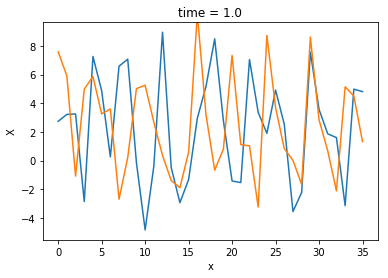

In [16]:
lref.history.X.isel(time=-1).plot()
l2.history.X.isel(time=-1).plot()

## Plot param task

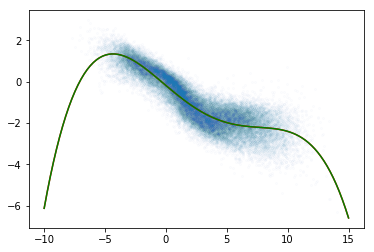

In [67]:
plt.scatter(lref.history.X, lref.history.B, s=5, alpha=0.01)
x = np.linspace(-10, 15, 100)
plt.plot(x, np.polyval(p, x), c='r')
plt.plot(x, poly(x, p[::-1]), c='g')

In [62]:
p = np.polyfit(lref.history.X.values.ravel(), lref.history.B.values.ravel(), 4)

In [63]:
p

array([-4.56102436e-04,  6.83394377e-03,  4.75755976e-03, -4.97199719e-01,
       -1.84655686e-01])

In [64]:
def poly(x, p, deg=4):
    return np.sum([p[i]*x**i for i in range(deg+1)], 0)

In [65]:
np.polyval(p, x[:2])

array([-6.13187065, -5.33284123])

In [66]:
poly(x[:2], p[::-1])

array([-6.13187065, -5.33284123])

## Build param L96

In [74]:
class L96TwoLevelUncoupledParam(object):
    def __init__(self, K=36, J=10, F=10, dt=0.001, param=None,
                 X_init=None, noprog=False, save_dt=0.1):
        self.K, self.J, self.F, self.dt = K, J, F, dt
        self.noprog = noprog
        self.param = param
        self.step_count = 0
        self.save_steps = int(save_dt / dt)
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy()
        self._history_X = [self.X.copy()]
        self._history_B = [np.zeros(self.X.shape)]

    def _rhs_X(self, X, B):
        """Compute the right hand side of the X-ODE."""
        dXdt = (
                -np.roll(X, -1) * (np.roll(X, -2) - np.roll(X, 1)) -
                X + self.F + B
        )
        return dXdt

    def step(self):
        # First get solution for X without updating Y
        B = self.param(self.X)
        
        k1_X = self.dt * self._rhs_X(self.X, 0)
        k2_X = self.dt * self._rhs_X(self.X + k1_X / 2, 0)
        k3_X = self.dt * self._rhs_X(self.X + k2_X / 2, 0)
        k4_X = self.dt * self._rhs_X(self.X + k3_X, 0)

        # Then update both
        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X) + self.dt * B

        self.step_count += 1

        if self.step_count % self.save_steps == 0:

            self._history_X.append(self.X.copy())
            self._history_B.append(B.copy())

    def iterate(self, time):
        steps = int(time / self.dt)
        for n in tqdm(range(steps), disable=self.noprog):
            self.step()

    @property
    def state(self):
        return np.concatenate([self.X])

    def set_state(self, x):
        self.X = x[:self.K]

    @property
    def history(self):
        dic = {}
        dic['X'] = xr.DataArray(self._history_X, dims=['time', 'x'], name='X')
        dic['B'] = xr.DataArray(self._history_B, dims=['time', 'x'], name='B')
        return xr.Dataset(
            dic,
            coords={'time': np.arange(len(self._history_X)) * self.dt, 'x': np.arange(self.K),
                    'y': np.arange(self.K * self.J)}
        )

In [80]:
class PolyParam():
    def __init__(self, p):
        self.p = p
    def __call__(self, x):
        return np.polyval(self.p, x)

In [81]:
lparam = L96TwoLevelUncoupledParam(param=PolyParam(p))

In [82]:
lparam.iterate(100)

In [83]:
lref.history.X.mean(), lparam.history.X.mean()

(<xarray.DataArray 'X' ()>
 array(2.520714), <xarray.DataArray 'X' ()>
 array(2.542514))

In [84]:
lref.history.X.std(), lparam.history.X.std()

(<xarray.DataArray 'X' ()>
 array(3.528028), <xarray.DataArray 'X' ()>
 array(3.538273))

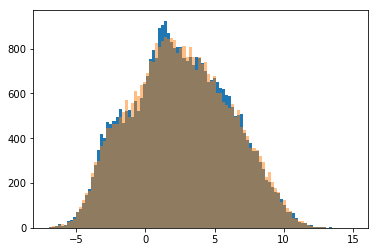

In [92]:
plt.hist(lref.history.X.values.ravel(), range=(-7, 15), bins=100)
plt.hist(lparam.history.X.values.ravel(), range=(-7, 15), bins=100, alpha=0.5);

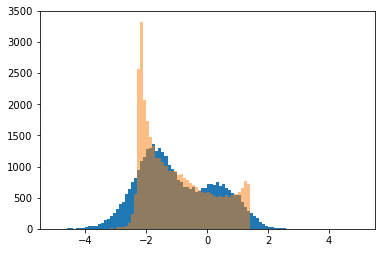

In [94]:
plt.hist(lref.history.B.values.ravel(), range=(-5, 5), bins=100)
plt.hist(lparam.history.B.values.ravel(), range=(-5, 5), bins=100, alpha=0.5);

## The simplest NN parameterization

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from sklearn.model_selection import train_test_split

/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [99]:
h = lref.history; h

<xarray.Dataset>
Dimensions:   (time: 10001, x: 36, y: 360)
Coordinates:
  * time      (time) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
  * x         (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y         (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    X         (time, x) float64 0.2055 0.05812 0.4093 0.9745 0.1429 0.5297 ...
    B         (time, x) float64 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 ...
    Y_mean    (time, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Y2_mean   (time, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    X_repeat  (time, y) float64 0.2055 0.2055 0.2055 0.2055 0.2055 0.2055 ...
    Y         (time, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [100]:
X= np.ravel(h.X); Y=np.ravel(h.B); X.shape

(360036,)

In [101]:
mean_x, mean_y = np.mean(X), np.mean(Y); mean_x, mean_y
std_x, std_y = np.std(X), np.std(Y); std_x, std_y

(3.5162178294837876, 1.2558989417523825)

In [102]:
X = (X - mean_x) / std_x
Y = (Y - mean_y) / std_y

In [103]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y)

In [104]:
X_train.shape, X_valid.shape

((270027,), (90009,))

In [131]:
model = keras.models.Sequential([
    Dense(5, input_shape=(1,), activation='elu'),
    #Dense(10, activation='elu'),
    Dense(1)
])
model.compile('adam', 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.fit(X_train, Y_train, batch_size=1024, epochs=10, validation_data=(X_valid, Y_valid))

Train on 270027 samples, validate on 90009 samples
Epoch 1/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1869
Epoch 2/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1867
Epoch 3/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1866
Epoch 4/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1868
Epoch 5/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1866
Epoch 6/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1866
Epoch 7/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1860 - val_loss: 0.1866
Epoch 8/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1859 - val_loss: 0.1866
Epoch 9/10
270027/270027 [==============================] - 0s 1us/step - loss: 0.1860 - val_loss: 0.

In [142]:
preds = model.predict(X_valid, 10_000)
test = np.linspace(-5, 5, 100); test_preds = model.predict(test)

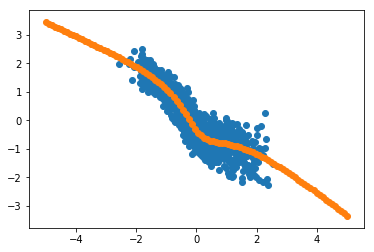

In [143]:
plt.scatter(X_valid[::100], Y_valid[::100])
#plt.scatter(X_valid[::100], preds[::100])
plt.scatter(test, test_preds)